In [2]:
#import itk
#from itk import ThinShellDemonsMetricv4 as tsd
#from itk import ConjugateGradientLineSearchOptimizerv4Template as itkc

import numpy as np
import math
import itkwidgets
from itkwidgets import view
import vtk

In [ ]:
# For TSD Registration

basepath = '/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/'
fixedMesh = itk.meshread(basepath + 'fixedMesh.vtk', itk.D)
movingMesh = itk.meshread(basepath + 'movingMesh.vtk', itk.D)

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType = itk.Mesh[itk.D, Dimension]
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

imageDiagonal = 5
spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

fixedImageSize = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Affine Transform Object
TransformType = itk.AffineTransform.D3
transform = TransformType.New()
transform.SetIdentity()
transform.SetCenter(minBounds + (maxBounds - minBounds)/2)

print('Transform Created')
print(transform)


MetricType = tsd.MD3
metric = MetricType.New()
metric.SetStretchWeight(1)
metric.SetBendWeight(5)
metric.SetGeometricFeatureWeight(10)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOn()
metric.UpdateFeatureMatchingAtEachIterationOff()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')

shiftScaleEstimator = itk.RegistrationParameterScalesFromPhysicalShift[MetricType].New()
shiftScaleEstimator.SetMetric(metric)
shiftScaleEstimator.SetVirtualDomainPointSet(metric.GetVirtualTransformedPointSet())


optimizer = itkc.D.New()
optimizer.SetNumberOfIterations( 50 )
optimizer.SetScalesEstimator( shiftScaleEstimator )
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.5 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

print('Optimizer created')


AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of Metric ', metric.GetValue())

finalTransform = registration.GetModifiableTransform()
numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

In [3]:
itk.meshwrite(movingMesh, "affineMovingMesh.vtk")

In [1]:
moving_mesh = itk.meshread('/media/pranjal.sahu/moredata/ITKPR30/ITK/ITK-build/Wrapping/Generators/Python/movingMesh_transformed.vtk')

NameError: name 'itk' is not defined

In [11]:
# For converting from PLY to VTK

import vtk

reader = vtk.vtkPLYReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129X1_SVJ_.ply')
reader.Update()
polydata1 = reader.GetOutput()

reader1 = vtk.vtkPLYReader()
reader1.SetFileName('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.ply')
reader1.Update()
polydata2 = reader1.GetOutput()

print(polydata1.GetNumberOfPoints())
print(polydata2.GetNumberOfPoints())


writer = vtk.vtkPolyDataWriter()
writer.SetFileName("/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk")
writer.SetFileVersion(42)
writer.SetInputData(polydata1)
writer.Update()

writer = vtk.vtkPolyDataWriter()
writer.SetFileName("/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk")
writer.SetFileVersion(42)
writer.SetInputData(polydata2)
writer.Update()

169954
174916


In [47]:
import vtk

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITKPR30/ITK/ITK-build/Wrapping/Generators/Python/movingMesh_transformed.vtk')
reader.Update()
polydata1 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk')
reader.Update()
polydata2 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk')
reader.Update()
polydata3 = reader.GetOutput()



reader = vtk.vtkPLYReader()
reader.SetFileName('A_J_skull_temp1.ply')
reader.Update()
polydata4 = reader.GetOutput()


reader = vtk.vtkPLYReader()
reader.SetFileName('NOD_SHILTJ_temp1.ply')
reader.Update()
polydata5 = reader.GetOutput()


In [48]:
# For cleaning the mesh

cleaner = vtk.vtkCleanPolyData()
cleaner.SetInputData(polydata4)
cleaner.SetTolerance(0.0001)
cleaner.Update()
polydata4 = cleaner.GetOutput()

gfilter1 = vtk.vtkTriangleFilter()
gfilter1.SetInputData(polydata4)
gfilter1.SetPassLines(False)
gfilter1.SetPassVerts(False)
gfilter1.Update()
polydata4 = gfilter1.GetOutput()

w = vtk.vtkPolyDataWriter()
w.SetFileName('A_J_skull_temp2.vtk')
w.SetFileVersion(42)
w.SetInputData(polydata4)
w.Update()



cleaner = vtk.vtkCleanPolyData()
cleaner.SetInputData(polydata5)
cleaner.SetTolerance(0.0001)
cleaner.Update()
polydata5 = cleaner.GetOutput()


gfilter1 = vtk.vtkTriangleFilter()
gfilter1.SetInputData(polydata5)
gfilter1.SetPassLines(False)
gfilter1.SetPassVerts(False)
gfilter1.Update()
polydata5 = gfilter1.GetOutput()


w = vtk.vtkPolyDataWriter()
w.SetFileName('NOD_SHILTJ_temp2.vtk')
w.SetFileVersion(42)
w.SetInputData(polydata5)
w.Update()

In [42]:
# For reducing the mesh sizes 


reader = vtk.vtkPolyDataReader()
reader.SetFileName('A_J_skull_temp1.vtk')
reader.Update()
polydata4 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_temp1.vtk')
reader.Update()
polydata5 = reader.GetOutput()


f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(polydata4)
f.PreserveTopologyOn()
f.Update()
polydata4 = f.GetOutput()
# cleaner = vtk.vtkCleanPolyData()
# cleaner.SetInputData(vtk_image1)
# cleaner.Update()
# vtk_image1 = cleaner.GetOutput()


f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(polydata5)
f.PreserveTopologyOn()
f.Update()
polydata5 = f.GetOutput()
# cleaner = vtk.vtkCleanPolyData()
# cleaner.SetInputData(vtk_image2)
# cleaner.Update()
# vtk_image2 = cleaner.GetOutput()

2022-03-14 20:45:20.852 (18733.965s) [        D76DD180]vtkDemandDrivenPipeline:666    ERR| vtkCompositeDataPipeline (0x5649c1dd19b0): Input port 0 of algorithm vtkPolyDataWriter(0x5649b5262f40) has 0 connections but is not optional.


AttributeError: 'vtkmodules.vtkIOLegacy.vtkPolyDataWriter' object has no attribute 'GetOutput'

In [17]:
print(polydata4.GetBounds())
print(polydata5.GetBounds())



(3.379319906234741, 17.99970054626465, 2.0339601039886475, 19.27669906616211, 0.6598290205001831, 17.98040008544922)
(3.234369993209839, 17.82859992980957, 1.812880039215088, 19.010900497436523, 0.7840330004692078, 18.19700050354004)


In [18]:
p1 = polydata5.GetPoints()
print(p1)

vtkPoints (0x55c62b2a93c0)
  Debug: Off
  Modified Time: 3434
  Reference Count: 2
  Registered Events: (none)
  Data: 0x55c62a366d00
  Data Array Name: Points
  Number Of Points: 186793
  Bounds: 
    Xmin,Xmax: (3.23437, 17.8286)
    Ymin,Ymax: (1.81288, 19.0109)
    Zmin,Zmax: (0.784033, 18.197)




In [36]:
a = 17.8286 - 3.23437
b = 19.0109 - 1.81288
c = 18.197 - 0.784033

print(a, b, c)

14.594230000000001 17.19802 17.412967


(186793, 3)


(array([ 5187.,  9162.,  9864., 11144., 21413., 44660., 42279., 26257.,
        14912.,  1915.]),
 array([ 3.23437 ,  4.693793,  6.153216,  7.612639,  9.072062, 10.531485,
        11.990908, 13.450331, 14.909754, 16.369177, 17.8286  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

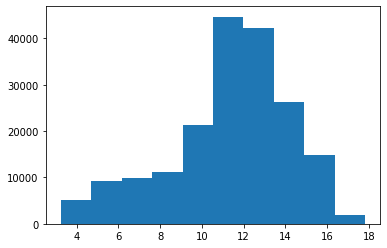

In [32]:
from vtk.util import numpy_support
import matplotlib.pyplot as plt

p1 = numpy_support.vtk_to_numpy(polydata5.GetPoints().GetData())
print(p1.shape)

plt.hist(p1[:, 0])

In [26]:
print(polydata5.GetPoints())

vtkPoints (0x5649bfa3cec0)
  Debug: Off
  Modified Time: 14445
  Reference Count: 2
  Registered Events: (none)
  Data: 0x5649b50f1ae0
  Data Array Name: Points
  Number Of Points: 186793
  Bounds: 
    Xmin,Xmax: (3.23437, 17.8286)
    Ymin,Ymax: (1.81288, 19.0109)
    Zmin,Zmax: (0.784033, 18.197)




In [24]:
# [STAR] For testing on ALPACA sample

reader = vtk.vtkPolyDataReader()
reader.SetFileName('A_J_skull_temp1.vtk')
reader.Update()
polydata4 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_temp1.vtk')
reader.Update()
polydata5 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/displacedMovingMesh.vtk')
reader.Update()
polydata6 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('Warped Source Mesh.vtk')
reader.Update()
polydata7 = reader.GetOutput()

#print(polydata4.GetNumberOfPoints())
print(polydata4.GetNumberOfPoints())
print(polydata6.GetNumberOfPoints())
#print(polydata7.GetNumberOfPoints())

#view(geometries=[polydata4,  polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata5, polydata6])
view(geometries=[polydata4, polydata5])
#view(geometries=[polydata4,  polydata7])

154091
938


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [40]:
# [STAR] For testing on the ThinShell sample

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/fixedMesh.vtk')
reader.Update()
polydata4 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/movingMesh.vtk')
reader.Update()
polydata5 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/displacedMovingMesh.vtk')
reader.Update()
polydata6 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/displacedMovingMesh1.vtk')
reader.Update()
polydata7 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/Wrapping/Generators/Python/affineMovingMesh.vtk')
reader.Update()
polydata8 = reader.GetOutput()


#print(polydata4.GetNumberOfPoints())
print(polydata4.GetNumberOfPoints())
print(polydata6.GetNumberOfPoints())
print(polydata8.GetNumberOfPoints())
#print(polydata7.GetNumberOfPoints())

#view(geometries=[polydata4,  polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata5, polydata6])
#view(geometries=[polydata4, polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata7])

view(geometries=[polydata4, polydata5, polydata8])

830
938
938


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [8]:
# For ICP registration

Dimension = 3

PointSetType = itk.PointSet[itk.F, Dimension]

fixedMesh = itk.meshread('/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk')
movingMesh = itk.meshread('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk')

fixedPS = PointSetType.New()
movingPS = PointSetType.New()

fixedPS.SetPoints(fixedMesh.GetPoints())
movingPS.SetPoints(movingMesh.GetPoints())

print(fixedMesh.GetNumberOfPoints(), movingMesh.GetNumberOfPoints())
print(fixedPS.GetNumberOfPoints(), movingPS.GetNumberOfPoints())

169954 174916
169954 174916


In [35]:
OptimizerType    = itk.LevenbergMarquardtOptimizer
MetricType       = itk.EuclideanDistancePointSetToPointSetMetricv4[type(fixedPS)]
#MetricType       = itk.EuclideanDistanceMetricv[type(fixedPS)]
TransformType    = itk.Rigid3DTransform[itk.D]
RegistrationType = itk.PointSetToPointSetRegistrationMethod[PointSetType, PointSetType]

#print(MetricType)

In [23]:
metric       = MetricType.New()
transform    = TransformType.New()
optimizer    = OptimizerType.New()
registration = RegistrationType.New()

In [24]:
numberOfIterations = 100
gradientTolerance  = 1e-5
valueTolerance     = 1e-5   
epsilonFunction    = 1e-6

#optimizer.SetScales(scales)
optimizer.SetNumberOfIterations(numberOfIterations)
optimizer.SetValueTolerance(valueTolerance)
optimizer.SetGradientTolerance(gradientTolerance)
optimizer.SetEpsilonFunction(epsilonFunction)

In [31]:
metric.SetFixedPointSet(fixedPS)
metric.SetMovingPointSet(movingPS)
metric.SetMovingTransform(TransformType)
metric.Initialize()

TypeError: in method 'itkObjectToObjectMetric33_SetMovingTransform', argument 2 of type 'itkTransformD33 *'

In [33]:
AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

itk.itkRigid3DTransformPython.itkRigid3DTransformD

In [25]:
def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


transform.SetIdentity()
registration.SetInitialTransformParameters(transform.GetParameters())
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.SetTransform(transform)
registration.SetFixedPointSet(fixedPointSet)
registration.SetMovingPointSet(movingPointSet)
registration.Update()

TypeError: in method 'itkPointSetToPointSetRegistrationMethodREGF3F3_SetMetric', argument 2 of type 'itkPointSetToPointSetMetricPSF3 *'

In [28]:
registration.SetMetric(metric)

TypeError: in method 'itkPointSetToPointSetRegistrationMethodREGF3F3_SetMetric', argument 2 of type 'itkPointSetToPointSetMetricPSF3 *'

In [29]:
type(metric)

itk.itkEuclideanDistancePointSetToPointSetMetricPython.itkEuclideanDistancePointSetToPointSetMetricv4PSF3

In [30]:
type(registration)

itk.itkPointSetToPointSetRegistrationMethodPython.itkPointSetToPointSetRegistrationMethodREGF3F3